# U.S. Religion Census: Religious Congregations and Membership Study, 2010 (County File)

In [1]:
import pdb
import random
import warnings
from collections import OrderedDict
from imp import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG, display

from hud_geo_conversions import read_zips_to_fips
from map_maker import draw_county_data_svg
from probplots import ProbPlots, plot_dists_pps
from religion_census import (read_all_denoms, read_cb, read_judaic_cngs,
                             read_judaic_denoms)
from utilities import (display_cb, is_outlier_instance, is_outlier_val,
                       read_fips_codes)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

SEED = 42
random.seed(SEED)

DATA_DIR    = '../Data/'

REL_DIR  = ''.join([DATA_DIR, 'Religion/'])
RELCEN_CB_FP  = ''.join([REL_DIR,
                         'US-Religion-Census-2010-County-File-CB.TXT'])
RELCEN_FP = ''.join([REL_DIR, 'US-Religion-Census-2010-County-File.DTA'])


def select_cols(df, suffix, exclude):
    return df.select(
        lambda x: x.endswith(suffix) and x not in exclude, axis=1)


## Basic summary

In [2]:
df_cb = read_cb(RELCEN_CB_FP)
df = read_judaic_denoms(RELCEN_FP)
display_cb(df_cb.head())
df.head()

,DESCRIPTION
VAR,
FIPS,FIPS code
STCODE,State code
CNTYCODE,County code
CNTYNAME,County name
STABBR,State abbreviation


,State,County,Tot_Cngs,Tot_No,Tot_Ra,ConsvJud_Cngs,ConsvJud_No,ConsvJud_Ra,OrthJud_Cngs,OrthJud_No,OrthJud_Ra,ReconJud_Cngs,ReconJud_No,ReconJud_Ra,RefJud_Cngs,RefJud_No,RefJud_Ra,UnionMessJews_Cngs
FIPS,,,,,,,,,,,,,,,,,,
01015,AL,Calhoun County,281.000,84615.000,713.620,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,113.000,0.950,0.000
01047,AL,Dallas County,140.000,26546.000,605.799,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,19.000,0.430,0.000
01069,AL,Houston County,210.000,81059.000,798.240,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,143.000,1.409,0.000
01073,AL,Jefferson County,1198.000,552254.000,838.700,1.000,1774.000,2.690,2.000,375.000,0.570,0.000,0.000,0.000,1.000,1971.000,2.990,0.000
01081,AL,Lee County,175.000,56996.000,406.399,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,124.000,0.880,0.000


In [3]:
df['Tot_Jews'] = select_cols(df, '_No', ['Tot_No']).sum(1)
df['Tot_JewCngs'] = select_cols(df, 'Cngs', ['Tot_Cngs']).sum(1)
df_no = df.select(lambda x: '_No' in x, axis=1)
df_cngs = df.select(lambda x: '_Cngs' in x, axis=1)


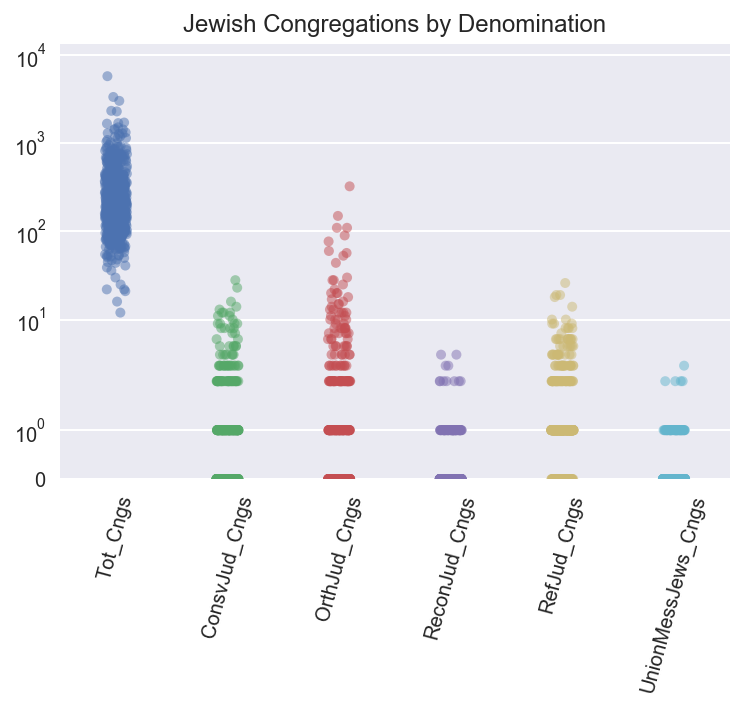

In [4]:

ax = sns.stripplot(data=df_cngs, jitter=True, alpha=.5)
ax.set_yscale('symlog')
[tick.label.set_rotation(75) for tick in ax.xaxis.get_major_ticks()]
    

plt.ylim(0)
plt.title('Jewish Congregations by Denomination')
plt.show()

## Cluster Analysis

In [163]:
to_drop   = ['Tot_Cngs']
# to_drop   = ['Tot_Cngs', 'UnionMessJews_Cngs']
# to_drop = ['Tot_Cngs', 'UnionMessJews_Cngs', 'ReconJud_Cngs']


cngs_df = (read_judaic_cngs(RELCEN_FP)
           .drop(to_drop, axis=1)
)
cngs_cols = cngs_df.columns.tolist()

### Dim reduction

In [164]:
from sklearn.decomposition import TruncatedSVD, PCA, NMF, FactorAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

class LogScaleByTotal(TransformerMixin):
    """Logs counts normalized by all count total."""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.log(X+1/np.sum(X+1))
    
class LogScaleBySubTotal(TransformerMixin):
    """Logs counts normalized by column total."""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        def f(x): return np.log(x+1/np.sum(x+1))
        return np.apply_along_axis(f, 1, X)
    
class LogStandardScaler(StandardScaler):
    """Standardized logged data."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def fit(self, X, y=None):
        return super().fit(np.log(X+1))
    
    def transform(self, X, y=None):
        return super().transform(np.log(X+1))


In [171]:
cngs_cols

['ConsvJud_Cngs',
 'OrthJud_Cngs',
 'ReconJud_Cngs',
 'RefJud_Cngs',
 'UnionMessJews_Cngs']

In [165]:
scaler = LogScaleByTotal()

reducer = PCA()

pipe = Pipeline([
    ('scaler', scaler),
#     ('snd', StandardScaler()),
    ('reducer', reducer)
])
reduced = pipe.fit_transform(cngs_df)
explained_variance = reducer.explained_variance_ratio_
print(explained_variance)

[ 0.57368284  0.1480713   0.12777467  0.08732673  0.06314445]


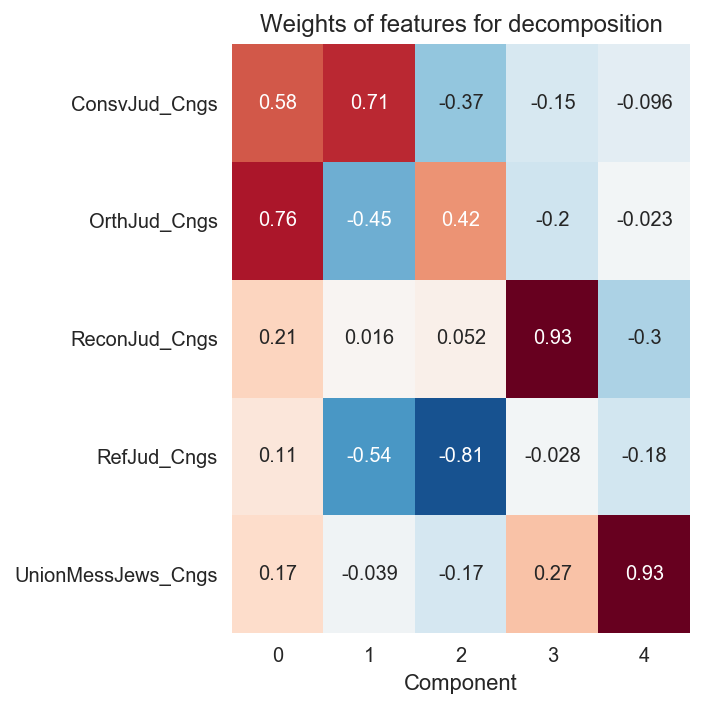

In [166]:
plt.figure(figsize=(5, 5))
sns.heatmap(reducer.components_.T, yticklabels=cngs_cols,
            cbar=False, annot=True)

plt.title('Weights of features for decomposition')
plt.xlabel('Component')

plt.tight_layout();

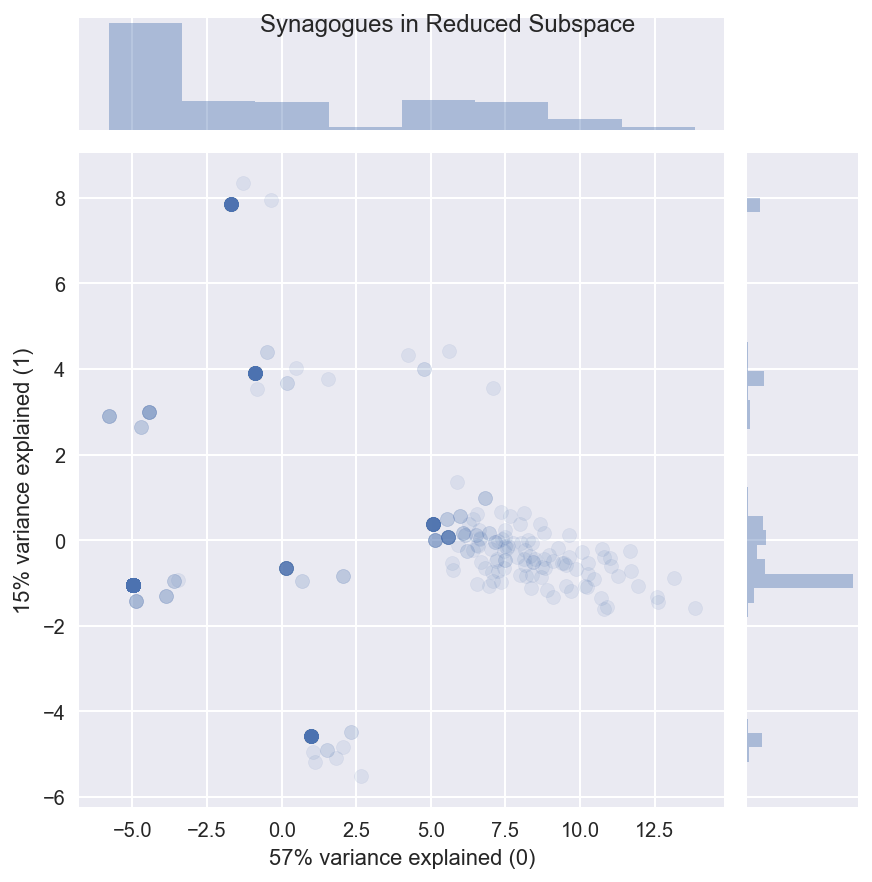

In [167]:
g = sns.jointplot(x=reduced[:, 0], y=reduced[:, 1],
                  alpha=.1, stat_func=None)



comp_0, comp_1, *_ = explained_variance
xlabel = '{:.0%} variance explained (0)'.format(comp_0)
ylabel = '{:.0%} variance explained (1)'.format(comp_1)

g.set_axis_labels(xlabel, ylabel)
g.fig.suptitle('Synagogues in Reduced Subspace')

plt.show()

### Clustering

In [142]:
def plot_clusters(x, y, data, hue, hue_values=None,
                  rich_legend=True, normalize=True, 
                  alpha=None, **kwargs):
    """Plots scatter with cluster labels as hue.
    
    Sorting testing visually with non-sorted plot
    
    Parameters
    ----------
    x, y, hue : names of variables in ``data``
        Inputs for plotting long-form data. See seaborn dcoumentation examples
        for interpretation.        
    data : DataFrame
        Dataset for plotting. If ``x`` and ``y`` are absent, this is
        interpreted as wide-form. Otherwise it is expected to be long-form. 
    hue_values : list of ints, optional
        Use only these cluster labels for hue, marking the rest as 'x' with
        the exception of outlier label -1 which is kept if present.
    rich_legend : True, bool
        If True, add value count info to clusters in legend, sorted in
        descending order. 
    normalize : True, bool
        If True, normalize value counts in legend.
    alpha : scalar, optional, default: None
        The alpha blending value, between 0 (transparent) and 1 (opaque)
    kwargs : key, value mappings
        Other keyword arguments are passed through to ``plt.scatter`` at draw
        time.
    """
    data = data.copy()
    if hue_values is not None:
        data.loc[:, hue] = data[hue].where(
            lambda x: x.isin(hue_values+[-1]), 'x')
    
    hue_order = None
    if rich_legend:
        cnts = data[hue].value_counts(normalize=normalize)
        new_legend = [(clust, '{:>6} | {:>8.3f}'.format(clust, cnts))
                      for clust, cnts in cnts.iteritems()]
        data = data.replace({hue: dict(new_legend)})
        # Sorting done by value_counts()
        hue_order = list(zip(*new_legend))[1]
    
    # TODO: Prevent alpha from affecting legend.
    return sns.lmplot(x=x, y=y, data=data, hue=hue,
                      fit_reg=False, legend=True,
                      scatter_kws=dict(alpha=alpha),
                      hue_order=hue_order, **kwargs
    )

In [143]:
from hdbscan import HDBSCAN

clust_data = reduced[:, :2]
clusterer = HDBSCAN(gen_min_span_tree=True).fit(clust_data)

labels = clusterer.labels_
clust_names = np.unique(labels)



dense_grp = [-1, 7, 8, 9, 10, 11, 12]
sparse_grp = [0, 1, 2, 3, 4, 5, 6]

names_used = sorted(dense_grp + sparse_grp)
names_actual = sorted(clust_names)

if names_used != names_actual:
    diff = set(names_used)^set(names_actual)
    diff.discard(-1)  # don't include -1 in check
    if diff:
        warnings.warn('{} missing or not present'.format(diff))

hue_values = None
# hue_values = dense_grp
# hue_values = sparse_grp

data = (pd.DataFrame(clust_data[:, :2])
        .rename(columns=lambda x: str(x))
        .assign(Cluster=labels)
)

/Users/mdlynch37/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:21: UserWarning: {13} missing or not present


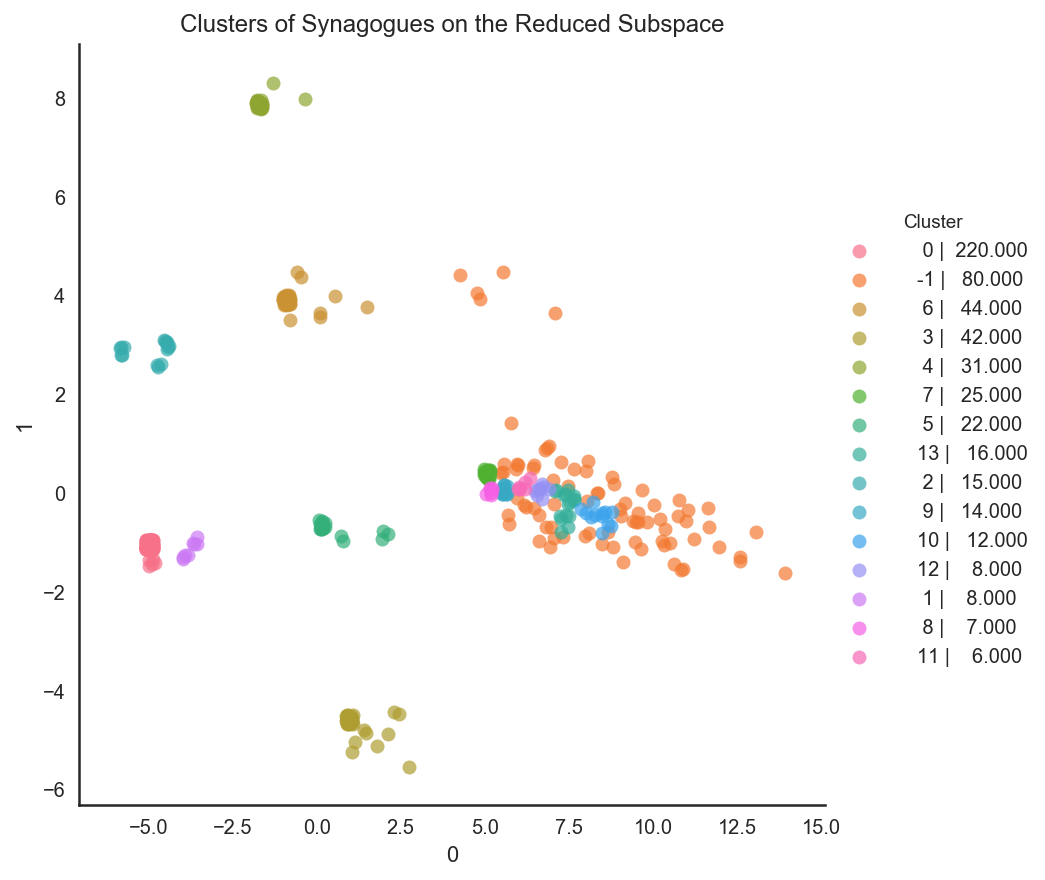

In [146]:
with sns.axes_style('white'):
    g = plot_clusters(x='0', y='1', data=data, hue='Cluster',
                  hue_values=hue_values, rich_legend=True,
                  alpha=.7, size=6, normalize=False,
                  x_jitter=.1, y_jitter=.1
    ).ax.set_title('Clusters of Synagogues on the Reduced Subspace')

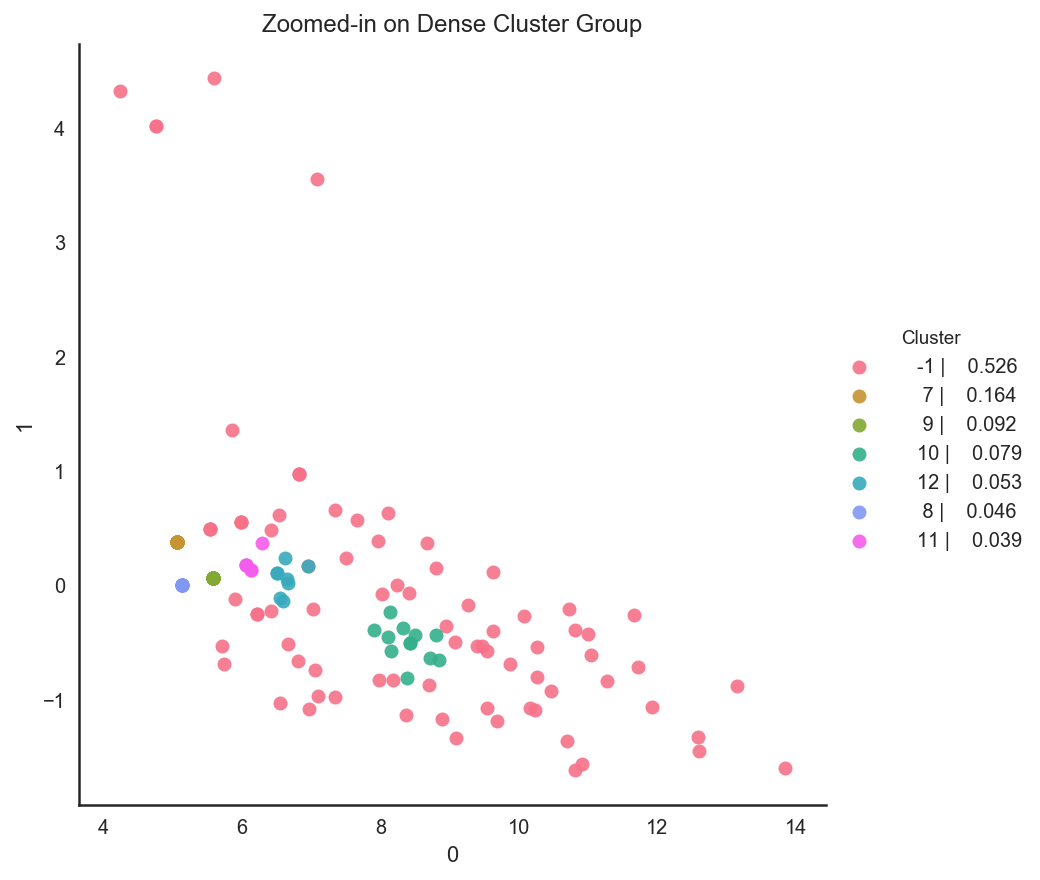

In [150]:
dense_data = data.loc[data.Cluster.isin(dense_grp), :]

with sns.axes_style('white'):
    g = plot_clusters(x='0', y='1', data=dense_data,
                      hue='Cluster', hue_values=None, rich_legend=True,
                      alpha=.9, size=6, normalize=True,
                      x_jitter=None, y_jitter=None
    ).ax.set_title('Zoomed-in on Dense Cluster Group')

With only sparse data to see HDBSCAN internals better

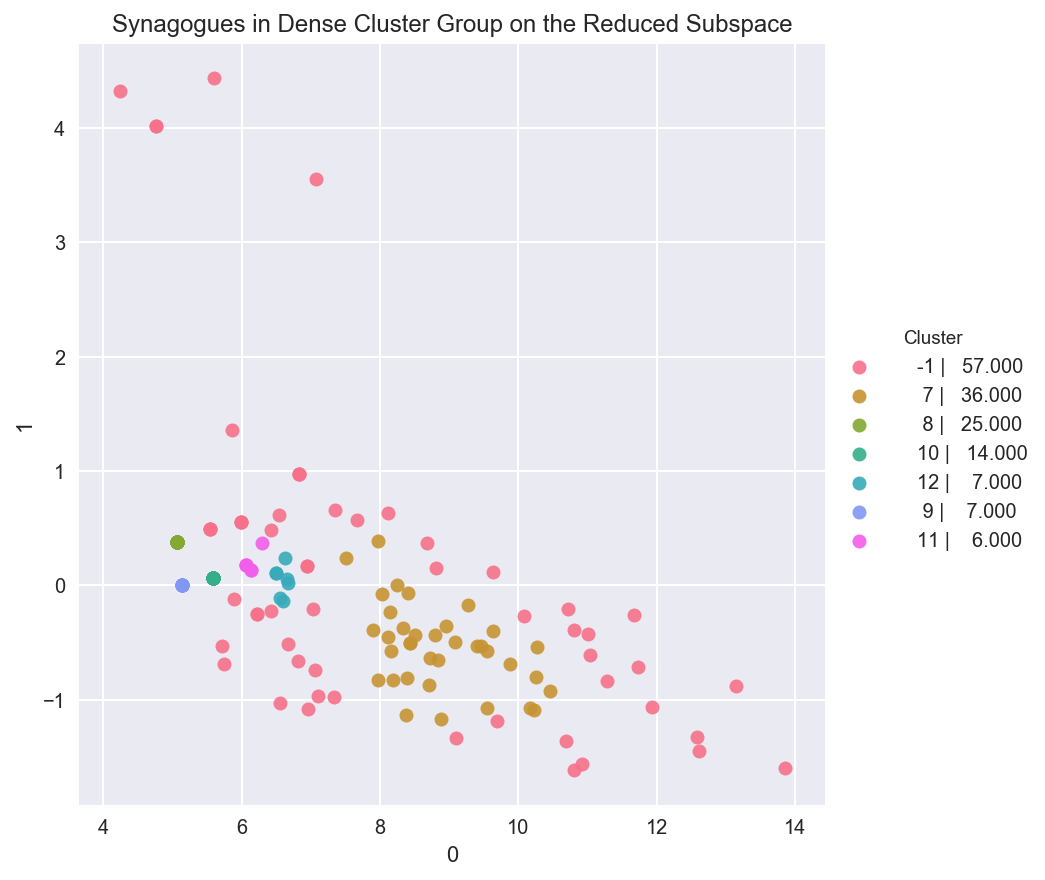

In [145]:
# from prior full clustering
clust_data_2 = data.loc[data.Cluster.isin(dense_grp), ['0', '1']].values

clusterer_2 = HDBSCAN(gen_min_span_tree=True).fit(clust_data_2)

labels_2 = clusterer_2.labels_
clust_names_2 = np.unique(labels_2)

data_2 = (pd.DataFrame(clust_data_2[:, :2])
          .rename(columns=lambda x: str(x))
          .assign(Cluster=labels_2)  
)
# To match labels previous plots
data_2.Cluster = data_2.Cluster.replace(clust_names_2, sorted(dense_grp))


g = plot_clusters(x='0', y='1', data=data_2,
                  hue='Cluster', hue_values=None, rich_legend=True,
                  alpha=.9, size=6, normalize=False,
                  x_jitter=None, y_jitter=None
).ax.set_title(
    'Synagogues in Dense Cluster Group on the Reduced Subspace')

/Users/mdlynch37/anaconda3/envs/py3/lib/python3.5/site-packages/hdbscan/plots.py:766: RuntimeWarning: divide by zero encountered in true_divide
  line_width = edge_linewidth * (np.log(self._mst.T[2].max() / self._mst.T[2]) + 1.0)


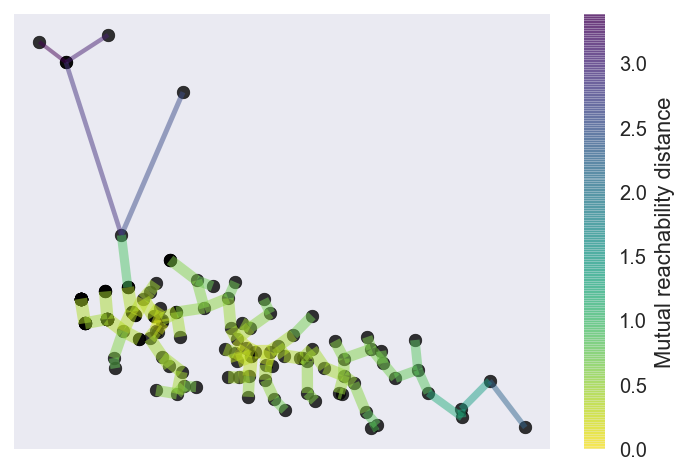

In [85]:
clusterer_2.minimum_spanning_tree_.plot()

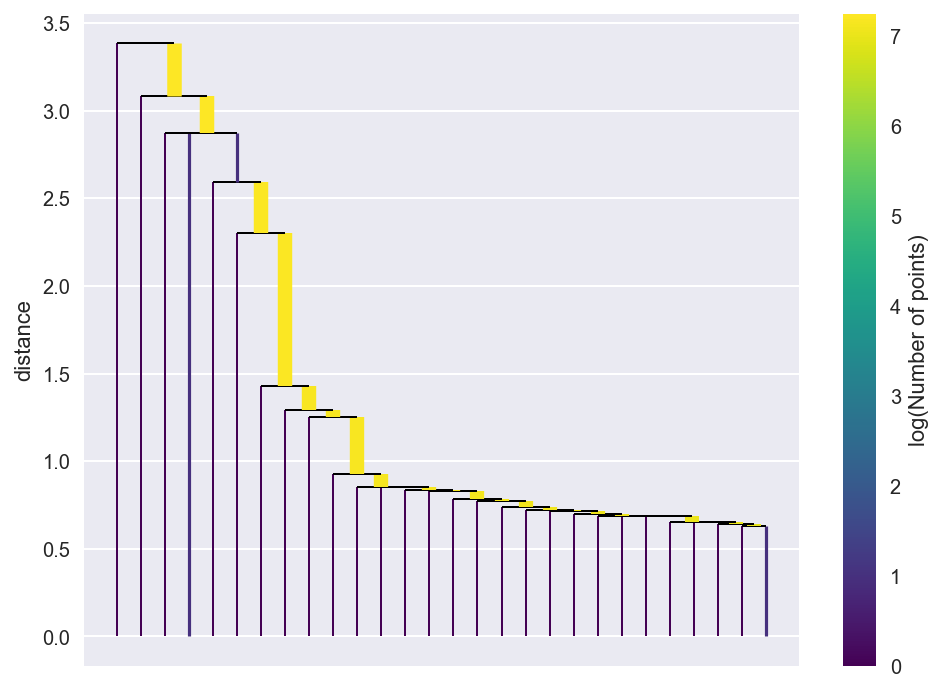

In [90]:
plt.figure(figsize=(8, 6))
clusterer_2.single_linkage_tree_.plot(truncate_mode='level', p=25)

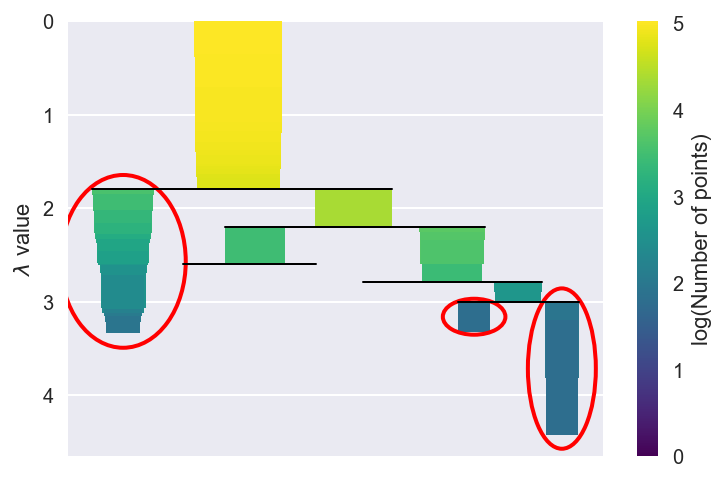

In [89]:
clusterer_2.condensed_tree_.plot(select_clusters=True, label_clusters=False,
                               log_size=True)

['#001c7f', '#017517', '#8c0900', '#7600a1', '#b8860b', '#006374']

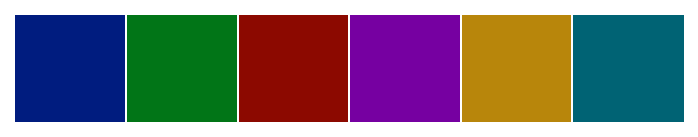

In [33]:
current_palette = sns.color_palette('dark')
sns.palplot(current_palette)
current_palette.as_hex()

In [39]:
sns.color_palette('dark').as_hex()[1:-1]

['#017517', '#8c0900', '#7600a1', '#b8860b']

['#f2f2f2', '#dbdbdb', '#c5c5c5', '#aeaeae', '#979797', '#808080']

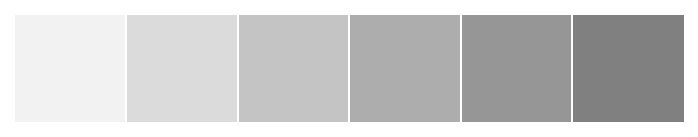

In [128]:
pal = sns.light_palette('gray')
sns.palplot(pal)
pal.as_hex()

In [ ]:
plt.legend()

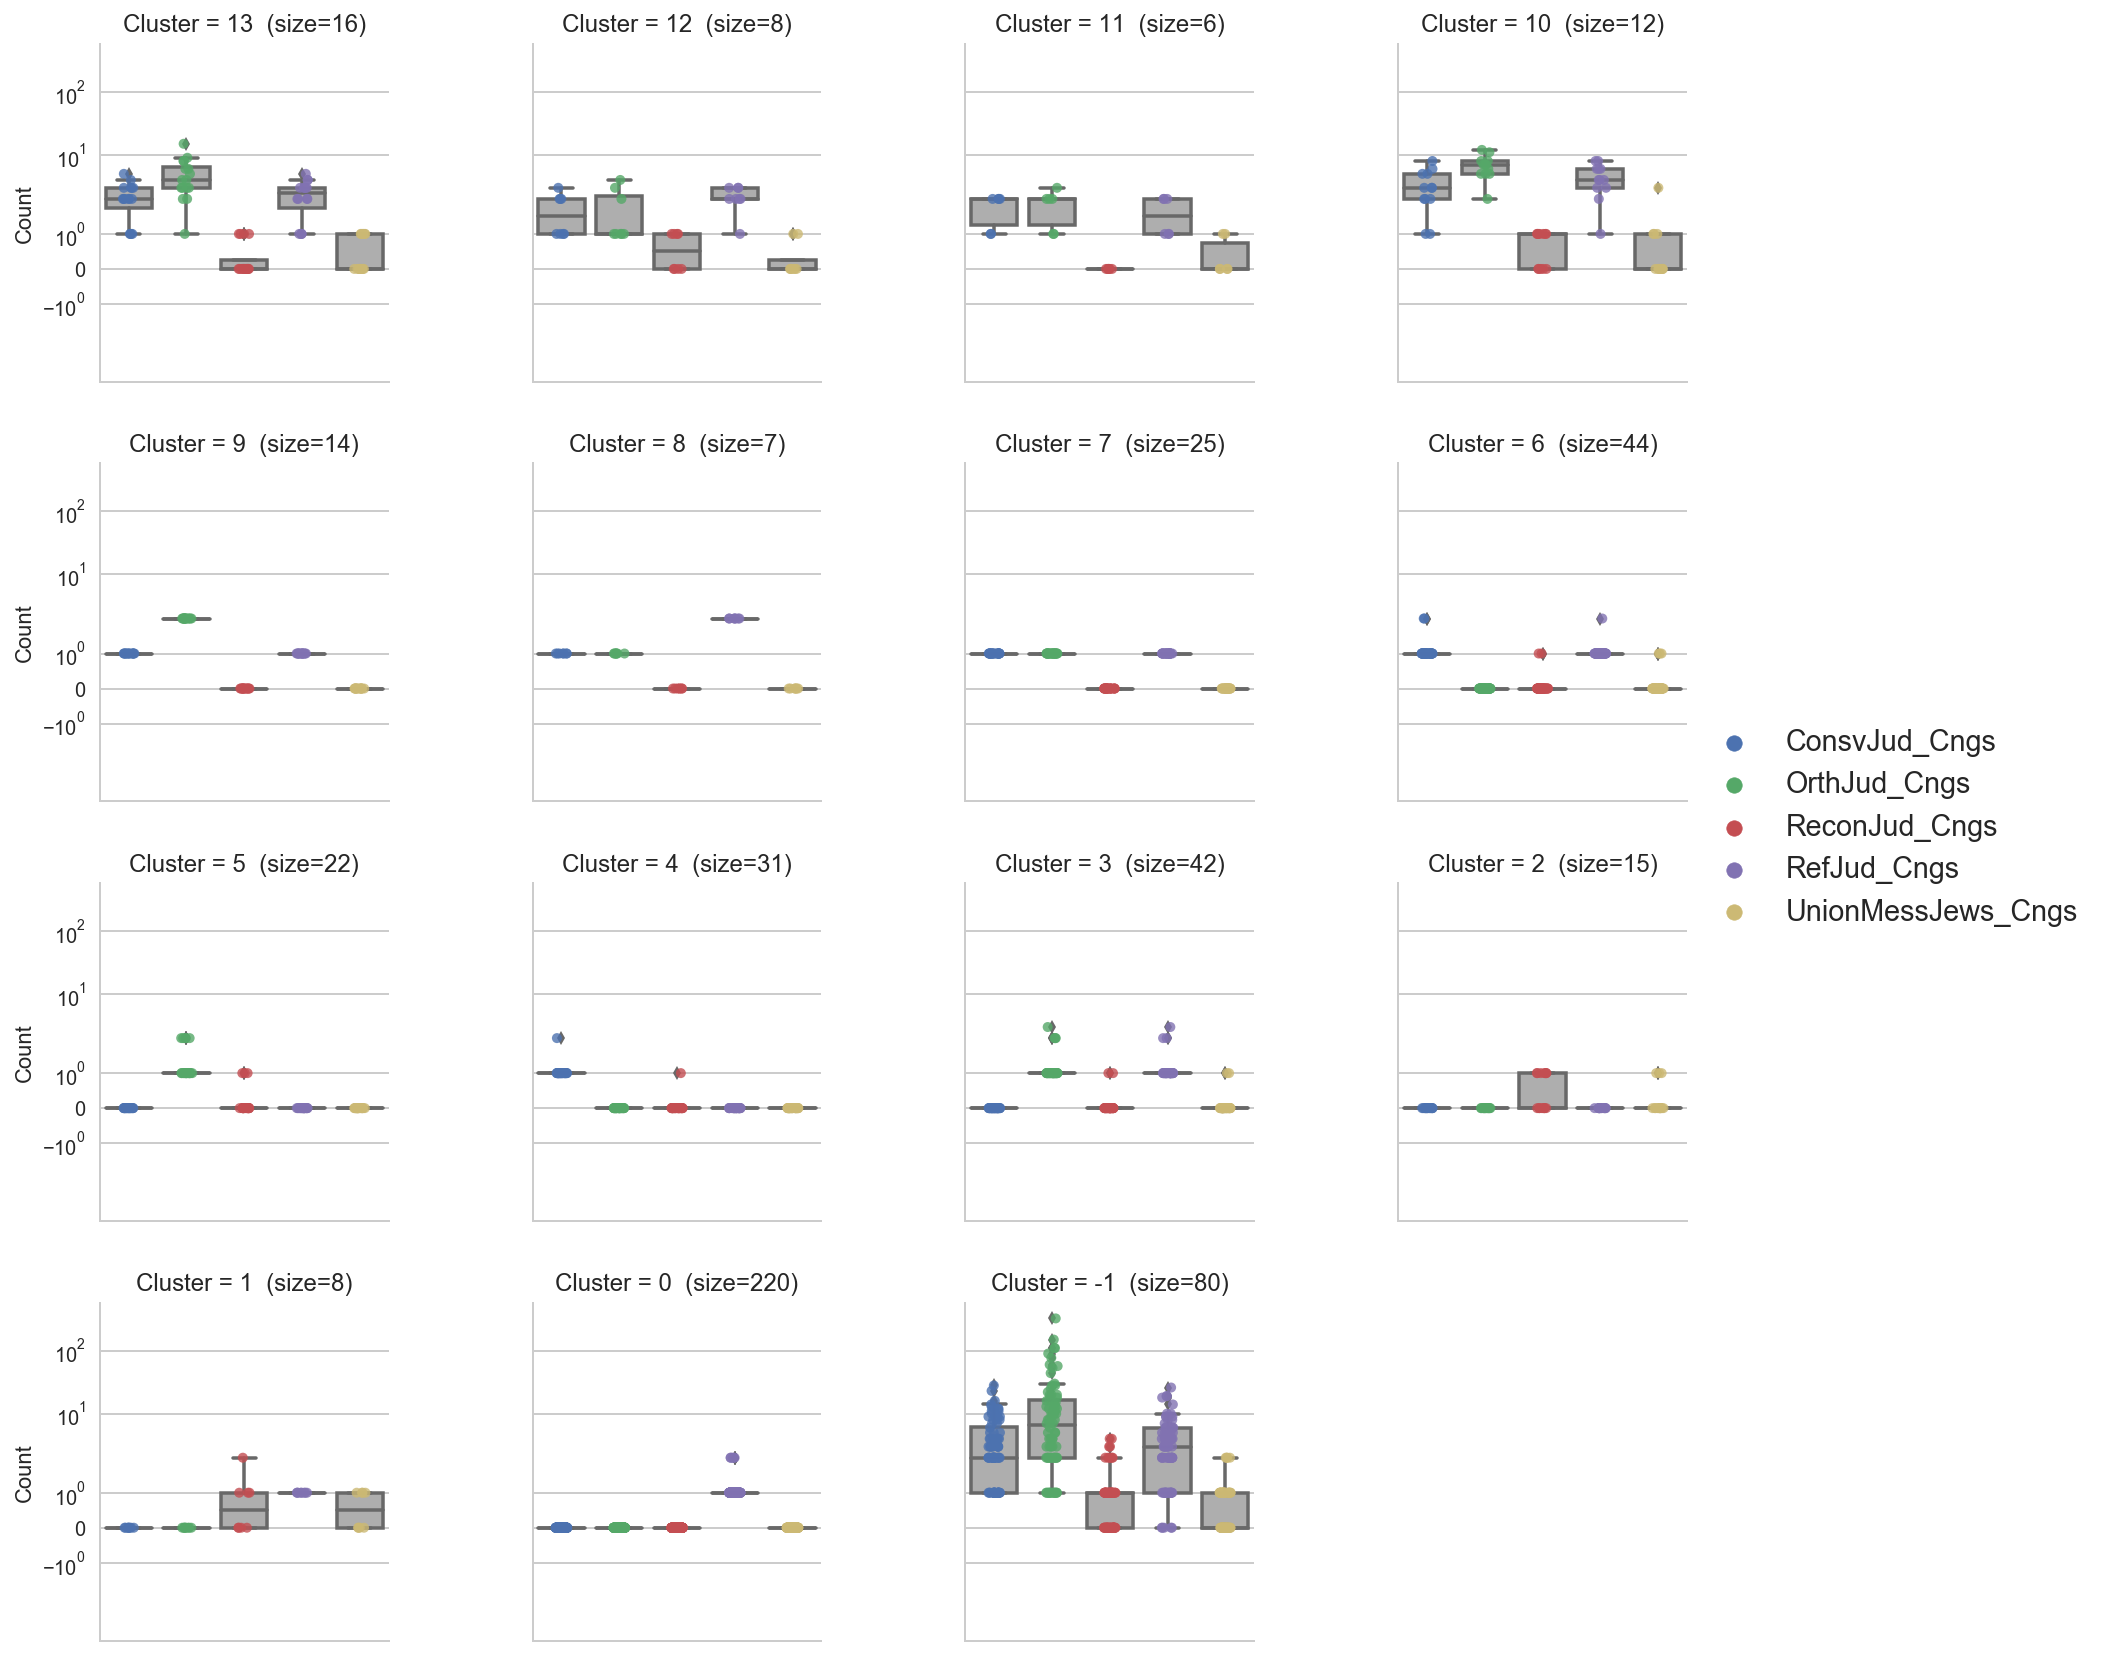

In [162]:
data = (cngs_df
        .assign(Cluster=labels)
        .melt(id_vars='Cluster', var_name='Denom', value_name='Count')
)

with sns.axes_style('whitegrid'):
    grid = sns.FacetGrid(data, col='Cluster', col_wrap=4,
                         col_order=sorted(data.Cluster.unique(), reverse=True),
                         sharey=True, size=3,

    )

    grid.map(
        sns.boxplot, 'Denom', 'Count',
        color='#aeaeae',
    )
    grid.map(
        sns.stripplot, 'Denom', 'Count', 'Denom',
        palette='deep',
        jitter=True,
        size=5,
        alpha=.8,
        edgecolor='gray',
    )
    grid.set(xticklabels='', xlabel='', yscale='symlog')

    grid.add_legend(fontsize='x-large')
    
    # rename facet titles to include size of cluster
    label_cnts = np.bincount(labels+1)[::-1]  # sorted by label val
    for n, ax in zip(label_cnts, grid.axes.flat):
        title = ax.get_title() + '  (size={})'.format(n)
        ax.set_title(title)

In [ ]:

# plt.figure(figsize=(10, 8))
# plt.ylim(0,10)
clust.condensed_tree_.plot(label_clusters=True, select_clusters=False,
                           leaf_separation=1, log_size=True)

In [ ]:
data = pd.DataFrame(clust_data).assign(Cluster=labels)

# data = pd.melt(data, id_vars='Cluster', value_name='Count',
#                var_name='Denomination')
x_y_hue = dict(x='Cluster', y='Count', hue='Denomination')

sns.pairplot(data, 'Cluster')

### Analysis

In [ ]:
data = df.assign(Cluster=labels)

data = pd.melt(data, id_vars='Cluster', value_name='Count',
               var_name='Denomination')
x_y_hue = dict(x='Cluster', y='Count', hue='Denomination')

In [ ]:
plt.figure(figsize=(10, 6))

sns.pointplot(x='Cluster', y='log_count', hue='Denomination',
              data=data.assign(log_count=np.log(data.Count+1)),
              scale=1, markers='x',
              estimator=np.median
             )
# plt.yscale('symlog')

In [ ]:
import yellowbrick as yb

In [ ]:
from yellowbrick.features.pcoords import ParallelCoordinates

In [ ]:
X = df.as_matrix()[:100]
y = (labels+1)[:100]

In [ ]:
np.unique(y)

In [ ]:
viz = yb.features.pcoords.ParallelCoordinates(features=['ConsvJud_Cngs', 'OrthJud_Cngs', 'ReconJud_Cngs', 'RefJud_Cngs'],
                                              classes=[str(lbl) for lbl in np.unique(y)])
viz.fit(X, y)
viz.transform(X)
viz.poof()

In [ ]:
plt.figure(figsize=(12, 8))
sns.stripplot(**x_y_hue, data=data,
              jitter=False, alpha=1, size=5, split=True)
plt.yscale('symlog')
